In [124]:
# merge_all.csv 파일을 사용하여 "가격 (원)" 컬럼의 값을 예측하는 모델을 만든다

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score

from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv1D

# load model
from keras.models import load_model

# import datatime
from datetime import datetime



In [49]:
# 데이터 불러오기
df = pd.read_csv('data/merge_all/merge_all.csv')
df.head()

# 데이터 전처리
# "거래년월일" 컬럼을 인덱스로 설정
df = df.set_index('거래년월일')
# "평균" 컬럼을 배추가격으로 설정
df = df.rename(columns={'평균':'배추가격'})
df.head()

,자동차용 경유 가격 (원),전월비(%),배추가격,거래량
거래년월일,,,,
2000-01-01,583.35,4.0,5600.0,102285.0
2000-01-02,583.35,4.0,5600.0,102285.0
2000-01-03,583.35,4.0,5600.0,102285.0
2000-01-04,583.35,4.0,5600.0,715338.0
2000-01-05,583.35,4.0,5620.0,340568.0


In [50]:
# lstm 모델에 사용할 데이터를 만든다

# 코드를 반복하여 "배추가격_N" 컬럼을 만든다
# "배추가격_N" 컬럼은 "배추가격" 컬럼의 N일 전 데이터를 사용한다
number = [1,5,20,40,80]
for i in number:
    df['배추가격_{}'.format(i)] = df['배추가격'].shift(i)

# "배추가격_N" 컬럼의 결측치를 제거한다
df = df.dropna()

In [100]:
df

,자동차용 경유 가격 (원),전월비(%),배추가격,거래량,배추가격_1,배추가격_5,배추가격_20,배추가격_40,배추가격_80
거래년월일,,,,,,,,,
2000-03-21,578.12,-0.8,8160.0,388330.0,8090.0,7950.0,7430.0,7790.0,5600.0
2000-03-22,578.12,-0.8,8160.0,465169.0,8160.0,7970.0,7430.0,8240.0,5600.0
2000-03-23,578.12,-0.8,8260.0,808309.0,8160.0,7970.0,7630.0,8690.0,5600.0
2000-03-24,578.12,-0.8,8440.0,121732.0,8260.0,7970.0,7730.0,8690.0,5600.0
2000-03-25,578.12,-0.8,8460.0,99408.0,8440.0,8090.0,7730.0,8390.0,5620.0
...,...,...,...,...,...,...,...,...,...
2022-11-26,1879.15,-8.0,6100.0,296250.0,6100.0,6300.0,7381.5,10623.0,37800.0
2022-11-27,1879.15,-8.0,6100.0,296250.0,6100.0,6260.0,7330.0,9706.0,35490.0
2022-11-28,1879.15,-8.0,5664.0,201478.0,6100.0,6100.0,7193.5,9193.0,35490.0


In [51]:
# "배추가격" 이외에 컬럼을 사용하여 "배추가격" 컬럼을 예측한다
# "배추가격_N" 컬럼을 X, "배추가격" 컬럼을 y로 설정한다
X = df.drop('배추가격', axis=1)
y = df['배추가격']

# 데이터를 학습용 데이터와 테스트용 데이터로 나눈다 (8:2)
X_train = X[:int(len(X)*0.8)]
X_test = X[int(len(X)*0.8):]
y_train = y[:int(len(y)*0.8)]
y_test = y[int(len(y)*0.8):]

# 데이터를 학습용 데이터와 검증용 데이터로 나눈다 (8:2)
X_train = X_train[:int(len(X_train)*0.8)]
X_val = X_train[int(len(X_train)*0.8):]
y_train = y_train[:int(len(y_train)*0.8)]
y_val = y_train[int(len(y_train)*0.8):]

# 데이터를 정규화한다
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, X_val.shape, X_test.shape

((5305, 8), (1061, 8), (1658, 8))

In [52]:
#  데이터를 3차원 배열로 변환한다
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

X_train.shape, X_val.shape, X_test.shape


((5305, 8, 1), (1061, 8, 1), (1658, 8, 1))

In [58]:
#  모델을 만든다 relu, tanh, sigmoid, softmax, Maxpooling, Dropout, BatchNormalization
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], 1), activation='tanh'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))


# 모델을 컴파일한다
model.compile(loss='mse', optimizer='adam', metrics=['mse'])


In [59]:
#  모델을 학습한다
early_stopping = EarlyStopping(patience=10)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100


2022-12-23 15:05:05.278076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-23 15:05:05.416151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  4/166 [..............................] - ETA: 2s - loss: 37829728.0000 - mse: 37829728.0000  

2022-12-23 15:05:05.666585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


166/166 [==============================] - ETA: 0s - loss: 27939106.0000 - mse: 27939106.0000

2022-12-23 15:05:08.293077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-23 15:05:08.349028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


166/166 [==============================] - 4s 18ms/step - loss: 27939106.0000 - mse: 27939106.0000 - val_loss: 12705515.0000 - val_mse: 12705515.0000
Epoch 2/100
166/166 [==============================] - 2s 15ms/step - loss: 9685769.0000 - mse: 9685769.0000 - val_loss: 7767813.0000 - val_mse: 7767813.0000
Epoch 3/100
166/166 [==============================] - 2s 14ms/step - loss: 5077917.0000 - mse: 5077917.0000 - val_loss: 3447578.0000 - val_mse: 3447578.0000
Epoch 4/100
166/166 [==============================] - 2s 14ms/step - loss: 2924187.5000 - mse: 2924187.5000 - val_loss: 7336320.0000 - val_mse: 7336320.0000
Epoch 5/100
166/166 [==============================] - 2s 13ms/step - loss: 2595681.0000 - mse: 2595681.0000 - val_loss: 2251490.2500 - val_mse: 2251490.2500
Epoch 6/100
166/166 [==============================] - 2s 14ms/step - loss: 2446995.5000 - mse: 2446995.5000 - val_loss: 2452995.7500 - val_mse: 2452995.7500
Epoch 7/100
166/166 [==============================] - 2s 13

In [60]:
#  모델을 평가한다
model.evaluate(X_test, y_test)

52/52 [==============================] - 1s 9ms/step - loss: 1299974.7500 - mse: 1299974.7500


[1299974.75, 1299974.75]

In [96]:
#  모델을 사용한다
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_pred.shape


52/52 [==============================] - 0s 5ms/step


(1658,)

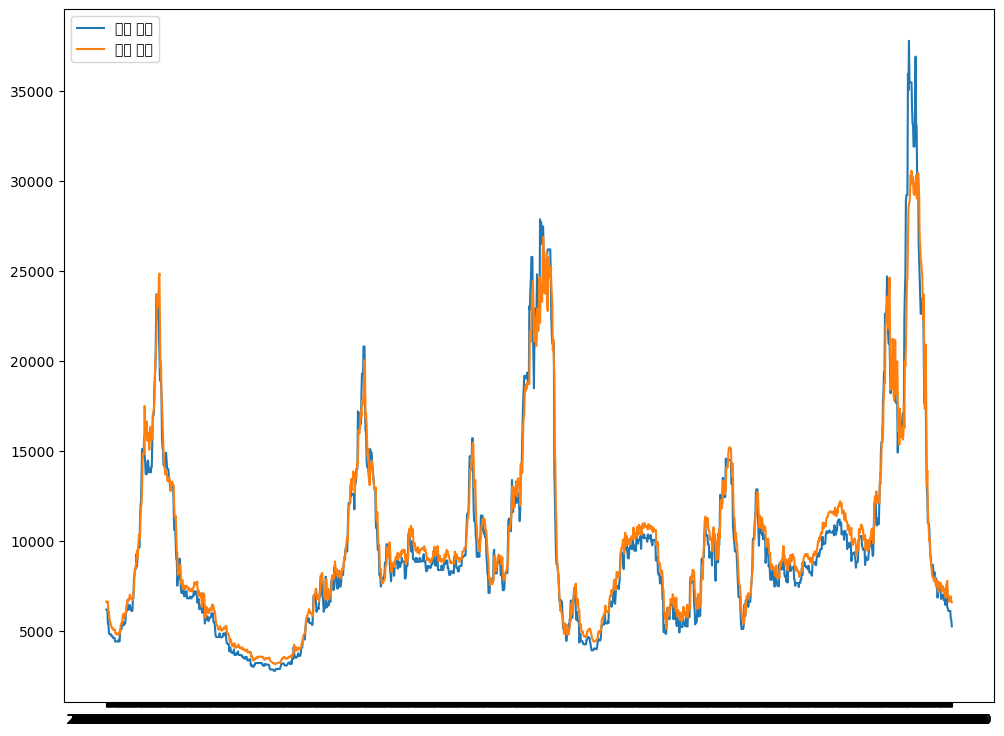

((1658,), (1658,))

In [94]:
#  모델을 시각화한다
plt.figure(figsize=(12, 9))
plt.plot(y_test, label='실제 가격')
plt.plot(y_pred, label='예측 가격')
plt.legend()
plt.show()

y_test.shape, y_pred.shape

In [77]:
#  모델 평가
# r2_score
r2_score(y_test, y_pred)


0.9586713381292935

In [78]:

#  mean_squared_error
mean_squared_error(y_test, y_pred)

1299974.8176673155

In [63]:
#  모델을 저장한다
model.save('model/LSTM_s2s.h5')

In [147]:
#  모델을 불러온다
model = load_model('model/LSTM_s2s.h5')


In [148]:
# model을 사용하여 배추 가격을 예측한다
# 2022년 12월 1일부터 2022년 12월 31일까지의 데이터를 만든다
new_df = pd.DataFrame()
# number = [1,5,20,40,80] # 1,5,20,40,80일 이동평균
for i in number:
    new_df['배추가격_N-'+str(i)] = [0] * 31

#  2022년 12월 1일부터 2022년 12월 31일까지의 날짜 데이터를 만든다
new_df['날짜'] = pd.date_range(start='2022-12-01', end='2022-12-31')
new_df = new_df.set_index('날짜')
# new_df 자동차용 경유 가격 (원)	전월비(%)	배추가격 컬럼 추가
new_df['자동차용 경유 가격 (원)'] = [0] * 31
new_df['전월비(%)'] = [0] * 31
new_df['거래량'] = [0] * 31
new_df = new_df[["자동차용 경유 가격 (원)",	"전월비(%)",	"거래량",'배추가격_N-1', '배추가격_N-5', '배추가격_N-20', '배추가격_N-40', '배추가격_N-80']]
new_df.head()

,자동차용 경유 가격 (원),전월비(%),거래량,배추가격_N-1,배추가격_N-5,배추가격_N-20,배추가격_N-40,배추가격_N-80
날짜,,,,,,,,
2022-12-01,0,0,0,0,0,0,0,0
2022-12-02,0,0,0,0,0,0,0,0
2022-12-03,0,0,0,0,0,0,0,0
2022-12-04,0,0,0,0,0,0,0,0
2022-12-05,0,0,0,0,0,0,0,0


In [ ]:
# new_df


In [149]:
# 2022년 12월 1일부터 2022년 12월 31일까지의 배추 가격을 예측한다
df['배추가격'] = model.predict(df)
df


1/1 [==============================] - 0s 319ms/step


2022-12-23 16:36:45.449635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-23 16:36:45.516202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


,자동차용 경유 가격 (원),전월비(%),거래량,배추가격_N-1,배추가격_N-5,배추가격_N-20,배추가격_N-40,배추가격_N-80,배추가격
날짜,,,,,,,,,
2022-12-01,0,0,0,0,0,0,0,0,1719.254639
2022-12-02,0,0,0,0,0,0,0,0,1719.254639
2022-12-03,0,0,0,0,0,0,0,0,1719.254639
2022-12-04,0,0,0,0,0,0,0,0,1719.254639
2022-12-05,0,0,0,0,0,0,0,0,1719.254639
2022-12-06,0,0,0,0,0,0,0,0,1719.254639
2022-12-07,0,0,0,0,0,0,0,0,1719.254639
2022-12-08,0,0,0,0,0,0,0,0,1719.254639
2022-12-09,0,0,0,0,0,0,0,0,1719.254639


새로운 데이터로 예측

In [104]:
# read price_baechoo.csv
price_new = pd.read_csv('data/price/price_baechoo.csv')
# 2022년 12월 데이터만 추출
price_new = price_new[price_new['구분'].str.contains('2022-12')]
# "구분" 컬럼을 인덱스로 설정
price_new = price_new.set_index('구분')
# "평균" 컬럼을 배추가격으로 설정
price_new = price_new.rename(columns={'평균':'배추가격'})
price_new.head()

,배추가격
구분,
2022-12-01,5462.0
2022-12-05,5982.0
2022-12-06,5502.0
2022-12-07,5488.0
2022-12-08,5408.0


In [110]:
# 새로운 y 값은 "배추가격" 컬럼이다
y_new = price_new['배추가격']

# 새로운 x 값을 생성한다
x_new = pd.DataFrame()



,배추가격_1,배추가격_5,배추가격_20,배추가격_40,배추가격_80
구분,,,,,


In [107]:
#  데이터를 정규화한다
scaler = MinMaxScaler()
x_new = scaler.fit_transform(x_new)
x_new = x_new.reshape(x_new.shape[0], x_new.shape[1], 1)

x_new.shape

(13, 5, 1)

In [108]:

#  데이터를 3차원 배열로 변환한다
X_new_3d = x_new.reshape(x_new.shape[0], x_new.shape[1], 1)

#  모델을 사용한다
y_pred_new = model.predict(X_new_3d)
y_pred_new = y_pred_new.reshape(-1)

#  예측결과 데이터프레임으로 만들기
y_pred_new = pd.DataFrame(y_pred_new, columns=['예측가격'])
y_pred_new

1/1 [==============================] - 0s 455ms/step


,예측가격
0,18.335093
1,18.335093
2,18.335093
3,18.335093
4,18.335093
5,18.335093
6,18.335093
7,18.335093
8,18.335093
9,18.335093


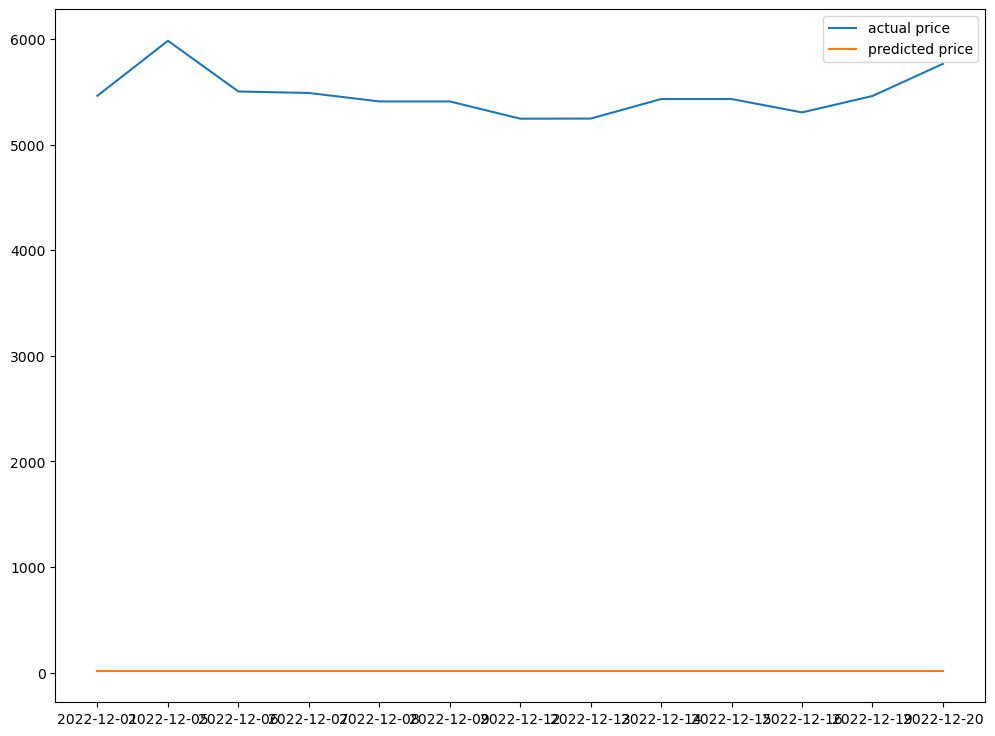

In [109]:
# 시각화
plt.figure(figsize=(12, 9))
plt.plot(y_new, label='actual price')
plt.plot(y_pred_new, label='predicted price')
plt.legend()
plt.show()